# Build simple AML pipeline end-to-end

## 0. Importing required libraries

In [527]:
import pandas as pd
import numpy as np
import GPy
import GPyOpt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform
from GPyOpt.methods import BayesianOptimization
from sklearn.svm import SVR

In [603]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth=100

## 1. Reading provided data

In [276]:
df = pd.read_csv('https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_Fire_Ins_Loss_only.csv')
df.head()

,loss,Exposure,Rating_Class,Sub_Rating_Class,Renewal_class,Sub_Renewal_Class,Property_size,Residents,Commercial,Norm_fire_risk,Norm_monthly_rent,Loan_mortgage,No_claim_Years,Previous_claims,Norm_area_m,Premium_remain,Premium_renew,Renewal_Type,crime_property_type,crime_residents,crime_area,crime_arson,crime_burglary,crime_neighbour_watch,crime_community,crime_risk,Geographical_risk,Weather_risk,ISO,ISO_cat,ISO_desc
0,0.07,3.0,H1,NaN,NaN,NaN,3.0,4.0,NaN,4.314082,758.287544,2.673639,2.251423,0.0,10.0,NaN,0.000000,B,1.209807,1.064398,1.066522,0.939346,1.708534,0.808015,1.040819,1.171366,0.284447,0.313157,5,ISO 5 - Modified or Semi Fire Resistive (MFR o...,which and floors. greater roof _—– modified an...
1,0.13,NaN,M1,NaN,NaN,NaN,6.0,1.0,NaN,4.171214,1060.660172,2.709158,2.084180,NaN,NaN,NaN,86.666667,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006305,0.889677,6,ISO 6 - Fire Resistive (FR),bearing are walls deck/cover precast and/or co...
2,0.02,NaN,M1,NaN,NaN,NaN,4.0,1.0,NaN,4.171214,1060.660172,2.709158,2.084180,NaN,8.0,NaN,86.666667,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019372,0.276507,1,ISO 1 Frame (combustible walls or roof),*BUR 1B and covers the *Single-ply wood/hardip...
3,0.13,NaN,M1,NaN,NaN,NaN,2.0,1.0,NaN,4.171214,1060.660172,2.709158,2.084180,NaN,12.0,NaN,86.666667,B,2.304699,1.912726,1.463283,1.632539,1.205554,1.999838,1.665336,1.779279,0.085413,0.124679,1,ISO 1 Frame (combustible walls or roof),"frame anchorage are wood. *Less Habitational, ..."
4,0.04,3.0,H1,NaN,NaN,NaN,4.0,3.0,NaN,4.314082,716.709146,2.711775,2.408759,0.0,NaN,100.0,0.000000,B,0.669145,0.430252,0.345801,0.638615,0.567431,0.751454,0.585363,0.729587,5.570830,0.703054,6,ISO 6 - Fire Resistive (FR),is roof deck structural on roof - poured occup...


## 2. Exploratory data analysis

Describing numerical features

In [277]:
df.describe()

,loss,Exposure,Property_size,Residents,Norm_fire_risk,Norm_monthly_rent,Loan_mortgage,No_claim_Years,Previous_claims,Norm_area_m,Premium_remain,Premium_renew,crime_property_type,crime_residents,crime_area,crime_arson,crime_burglary,crime_neighbour_watch,crime_community,crime_risk,Geographical_risk,Weather_risk,ISO
count,1217.000000,210.000000,1216.000000,1212.000000,1217.000000,1217.000000,196.000000,1217.000000,353.000000,1047.000000,184.000000,1217.000000,923.000000,910.000000,923.000000,916.000000,922.000000,923.000000,903.000000,923.000000,1211.000000,1213.000000,1217.000000
mean,0.080477,2.809524,3.820724,2.514026,4.040762,1852.694145,3.286935,1.010640,0.320084,34.265521,69.201087,71.641081,1.002025,0.958211,0.989317,0.954384,1.044832,0.982719,0.962596,0.992618,1.125001,0.918192,2.889071
std,0.050425,0.726731,1.598589,1.318972,0.232445,1678.089181,0.243295,0.769526,0.500960,25.261731,43.405041,32.708544,0.439617,0.403047,0.407156,0.238484,0.523383,0.490376,0.254882,0.358018,1.918566,1.094440,1.598731
min,0.010000,1.000000,1.000000,1.000000,3.776480,500.000000,2.673639,0.000000,0.000000,0.000000,0.000000,0.000000,0.083394,0.360578,0.065520,0.472193,0.154595,0.000000,0.522494,0.175763,0.000000,0.000000,1.000000
25%,0.040000,2.000000,3.000000,1.000000,3.898949,783.693499,3.144307,0.000000,0.000000,16.000000,4.000000,58.695652,0.699736,0.625186,0.687961,0.739102,0.572656,0.686813,0.739831,0.767780,0.091752,0.273559,2.000000
50%,0.070000,3.000000,3.500000,2.000000,3.898949,1232.882801,3.339025,1.048147,0.000000,30.000000,99.000000,85.564503,0.912543,0.903848,0.924562,0.942690,1.019386,0.989819,0.924495,0.974872,0.392954,0.550059,3.000000
75%,0.100000,3.000000,5.000000,4.000000,4.171214,2248.569323,3.474623,1.665109,0.832555,47.000000,100.000000,97.560858,1.209807,1.210431,1.190282,1.130489,1.322650,1.191823,1.110430,1.193020,1.059832,1.204226,4.000000
max,0.200000,5.000000,8.000000,6.000000,5.123351,13296.240070,3.714656,2.639501,1.893018,208.000000,100.000000,100.000000,2.952696,2.970605,4.145968,1.926021,2.391149,4.322882,2.043525,2.641966,8.548033,9.098934,6.000000


Data types of provided data

In [278]:
df.dtypes

loss                     float64
Exposure                 float64
Rating_Class              object
Sub_Rating_Class          object
Renewal_class             object
Sub_Renewal_Class         object
Property_size            float64
Residents                float64
Commercial                object
Norm_fire_risk           float64
Norm_monthly_rent        float64
Loan_mortgage            float64
No_claim_Years           float64
Previous_claims          float64
Norm_area_m              float64
Premium_remain           float64
Premium_renew            float64
Renewal_Type              object
crime_property_type      float64
crime_residents          float64
crime_area               float64
crime_arson              float64
crime_burglary           float64
crime_neighbour_watch    float64
crime_community          float64
crime_risk               float64
Geographical_risk        float64
Weather_risk             float64
ISO                        int64
ISO_cat                   object
ISO_desc  

## 3. Feature enginering

Adding new features:
- "Residents_per_size" = "Residents" / "Property_size"
- "Overall_risk" = ("Norm_fire_risk" + "crime_risk" + "Geographical_risk" + "Weather_risk")/4

In [279]:
df['Residents_per_size'] = df.Residents/df.Property_size
# copy df to keep original one unchanged, but impute a new one for overall risk calcualtion
# treat NaN as 0 for this calculation
temp_df = df.copy()
temp_df.Norm_fire_risk.fillna(0, inplace=True)
temp_df.crime_risk.fillna(0, inplace=True)
temp_df.Geographical_risk.fillna(0, inplace=True)
temp_df.Weather_risk.fillna(0, inplace=True)
df['Overall_risk'] = ( temp_df.Norm_fire_risk + temp_df.crime_risk + temp_df.Geographical_risk + temp_df.Weather_risk)/4

pandas.set_option('display.max_columns', None)
df.head()

,loss,Exposure,Rating_Class,Sub_Rating_Class,Renewal_class,Sub_Renewal_Class,Property_size,Residents,Commercial,Norm_fire_risk,Norm_monthly_rent,Loan_mortgage,No_claim_Years,Previous_claims,Norm_area_m,Premium_remain,Premium_renew,Renewal_Type,crime_property_type,crime_residents,crime_area,crime_arson,crime_burglary,crime_neighbour_watch,crime_community,crime_risk,Geographical_risk,Weather_risk,ISO,ISO_cat,ISO_desc,Residents_per_size,Overall_risk
0,0.07,3.0,H1,NaN,NaN,NaN,3.0,4.0,NaN,4.314082,758.287544,2.673639,2.251423,0.0,10.0,NaN,0.000000,B,1.209807,1.064398,1.066522,0.939346,1.708534,0.808015,1.040819,1.171366,0.284447,0.313157,5,ISO 5 - Modified or Semi Fire Resistive (MFR o...,which and floors. greater roof _—– modified an...,1.333333,1.520763
1,0.13,NaN,M1,NaN,NaN,NaN,6.0,1.0,NaN,4.171214,1060.660172,2.709158,2.084180,NaN,NaN,NaN,86.666667,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006305,0.889677,6,ISO 6 - Fire Resistive (FR),bearing are walls deck/cover precast and/or co...,0.166667,1.266799
2,0.02,NaN,M1,NaN,NaN,NaN,4.0,1.0,NaN,4.171214,1060.660172,2.709158,2.084180,NaN,8.0,NaN,86.666667,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019372,0.276507,1,ISO 1 Frame (combustible walls or roof),*BUR 1B and covers the *Single-ply wood/hardip...,0.250000,1.116773
3,0.13,NaN,M1,NaN,NaN,NaN,2.0,1.0,NaN,4.171214,1060.660172,2.709158,2.084180,NaN,12.0,NaN,86.666667,B,2.304699,1.912726,1.463283,1.632539,1.205554,1.999838,1.665336,1.779279,0.085413,0.124679,1,ISO 1 Frame (combustible walls or roof),"frame anchorage are wood. *Less Habitational, ...",0.500000,1.540146
4,0.04,3.0,H1,NaN,NaN,NaN,4.0,3.0,NaN,4.314082,716.709146,2.711775,2.408759,0.0,NaN,100.0,0.000000,B,0.669145,0.430252,0.345801,0.638615,0.567431,0.751454,0.585363,0.729587,5.570830,0.703054,6,ISO 6 - Fire Resistive (FR),is roof deck structural on roof - poured occup...,0.750000,2.829388


## 4. CV partitioning

In [280]:
y = df.loss.copy()
X = df.copy().drop('loss', axis=1)
# splitting data to test and train as 15% vs. 85%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, test_size=0.15, random_state=7)

## 5. Build pipelines

I am using ElasticNet instead of Linear Regression t enable hyperparameters optimization. Usual Linear Regression simply has no hyperparameters to tune.

In [281]:
# defining numeric features
numeric_features = X_train.select_dtypes(include=np.number).columns

# defining categorical features
categorical_features = X_train.select_dtypes(include=np.object).columns.drop('ISO_desc')

# defining text features
text_features = 'ISO_desc'

# defining pipeline for numeric data
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)), 
    ('scaler', StandardScaler())
])

# defining pipeline for categorical data
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# defining pipeline for text data
text_pipeline = Pipeline(steps=[
    ('tf_idf', TfidfVectorizer(stop_words='english'))
])

# defining preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features),
        ('text', text_pipeline, text_features)
    ]
)

# Append estimator to preprocessing pipeline.
# Now we have a full prediction pipeline.
est = Pipeline(steps=[('preprocessor', preprocessor),
                      ('EN', ElasticNet(random_state=7))
])

#fit the model
est.fit(X_train, y_train)

print("Model MAE: %.7f" % mean_absolute_error(y_test, est.predict(X_test)))

Model MAE: 0.0403518


## 6. Optimize model hyperparameters

### Optimization using Grid Search

In [282]:
# defining dictionary with parameters to serach through
params = dict(EN__l1_ratio = np.arange(0.1, 1, 0.05), EN__alpha = np.arange(0, 2, 0.1))
# define grid search
gs = GridSearchCV(estimator=est, param_grid=params, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=3, cv=5)
# execute grid search
gs.fit(X_train,y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  1.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

Printing best parameters, estimator and its score

In [283]:
gs.best_params_

{'EN__alpha': 0.1, 'EN__l1_ratio': 0.1}

In [284]:
gs.best_estimator_

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=0,
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                              

In [285]:
print("Optimized model MAE: %.7f" % (-1*gs.best_score_)) 

Optimized model MAE: 0.0400362


### Optimization using Random Search

In [287]:
# defining dictionary with parameters to serach through
params_dist = dict(EN__l1_ratio = uniform(loc=0, scale=1), EN__alpha = uniform(loc=0, scale=2))
# define Random Search
rs = RandomizedSearchCV(estimator=est, param_distributions=params_dist, scoring='neg_mean_absolute_error', n_iter=1000, n_jobs=-1, verbose=3, random_state=7, cv=5)
#execute Random Search
rs.fit(X_train,y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  2.6min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                                                     

Printing best parameters, estimator and its score

In [289]:
rs.best_params_

{'EN__alpha': 0.012753656202565189, 'EN__l1_ratio': 0.028049402896189624}

In [290]:
rs.best_estimator_

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=0,
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                              

In [291]:
print("Optimized model MAE: %.7f" % (-1*rs.best_score_)) 

Optimized model MAE: 0.0384587


### Optimization using Bayesian Optimization

In [292]:
# defining numeric features
numeric_features = X_train.select_dtypes(include=np.number).columns

# defining categorical features
categorical_features = X_train.select_dtypes(include=np.object).columns.drop('ISO_desc')

# defining text features
text_features = 'ISO_desc'

# defining pipeline for numeric data
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)), 
    ('scaler', StandardScaler())
])

# defining pipeline for categorical data
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# defining pipeline for text data
text_pipeline = Pipeline(steps=[
    ('tf_idf', TfidfVectorizer(stop_words='english'))
])

# defining preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features),
        ('text', text_pipeline, text_features)
    ]
)

# defining single function for our regression in order to run Bayesian optimization
def ENR(args):
    
    # Append estimator to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    est = Pipeline(steps=[('preprocessor', preprocessor),
                          ('EN', ElasticNet(l1_ratio=float(args[0][0]), alpha=float(args[0][1]), random_state=7))
    ])

    #fit the model
    est.fit(X_train, y_train)
    #return model score as single value
    score = cross_val_score(est, X_test, y_test, scoring='neg_mean_absolute_error').mean()
    
    score = np.array(score)
    return score

In [293]:
# define parameters distribution to search through
domains = [{'name':'l1_ratio', 'type':'continuous', 'domain': (0,1)},
      {'name': 'alpha', 'type': 'continuous', 'domain': (0,2)}
          ]
# define Bayesian optimizer
optimizer = BayesianOptimization(f=ENR, model_type='GP', acquisition_type='EI', domain=domains, maximize=True)
# execute optimization
optimizer.run_optimization(max_iter=100, verbosity=True)

num acquisition: 1, time elapsed: 0.41s
num acquisition: 2, time elapsed: 0.86s
num acquisition: 3, time elapsed: 1.30s
num acquisition: 4, time elapsed: 1.75s
num acquisition: 5, time elapsed: 2.19s
num acquisition: 6, time elapsed: 2.84s
num acquisition: 7, time elapsed: 3.47s
num acquisition: 8, time elapsed: 4.16s
num acquisition: 9, time elapsed: 4.80s
num acquisition: 10, time elapsed: 5.48s
num acquisition: 11, time elapsed: 6.15s
num acquisition: 12, time elapsed: 6.59s
num acquisition: 13, time elapsed: 7.10s
num acquisition: 14, time elapsed: 7.62s
num acquisition: 15, time elapsed: 8.13s
num acquisition: 16, time elapsed: 9.04s
num acquisition: 17, time elapsed: 9.83s
num acquisition: 18, time elapsed: 10.68s
num acquisition: 19, time elapsed: 11.40s
num acquisition: 20, time elapsed: 11.85s
num acquisition: 21, time elapsed: 12.33s
num acquisition: 22, time elapsed: 13.11s
num acquisition: 23, time elapsed: 13.84s
num acquisition: 24, time elapsed: 14.56s
num acquisition: 2

Plot and print results of optimization

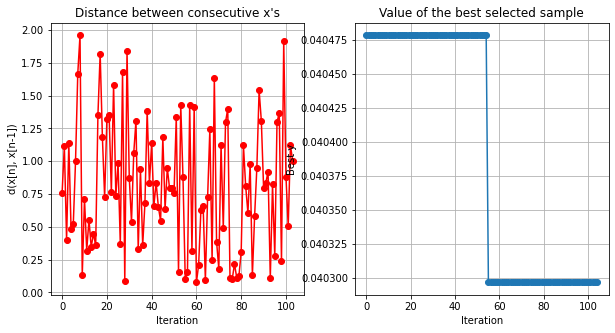

In [294]:
optimizer.plot_convergence()

In [295]:
print("Optimal parameters are l1_ratio = %.7f and alpha = %.7f." % (optimizer.x_opt[0], optimizer.x_opt[1]))

print("Optimal function value is %.5f" % optimizer.fx_opt)

Optimal parameters are l1_ratio = 0.0421304 and alpha = 0.1426798.
Optimal function value is 0.04030


## 7. Report results

Here I provide summary of three optimized models

In [605]:
# defining dataframe to collect results for leaderboard

leaderboard_df = pd.DataFrame(columns=['model','optimizer','best_params','best_score'])

# adding ElasticNet results to leaderboard
leaderboard_df = leaderboard_df.append({'model':"ElasticNet", 'optimizer': "Grid Search", 
                                        'best_params': "alpha = %.7f | l1_ratio = %.7f" % (gs.best_params_['EN__alpha'], gs.best_params_['EN__l1_ratio']),
                                        'best_score': -1*gs.best_score_}, ignore_index=True)

leaderboard_df = leaderboard_df.append({'model':"ElasticNet", 'optimizer': "Random Search", 
                                        'best_params': "alpha = %.7f | l1_ratio = %.7f" % (rs.best_params_['EN__alpha'], rs.best_params_['EN__l1_ratio']), 
                                        'best_score': -1*rs.best_score_}, ignore_index=True)

leaderboard_df = leaderboard_df.append({'model':"ElasticNet", 'optimizer': "Bayesian Optimization", 
                                        'best_params': "alpha = %.7f | l1_ratio = %.7f" % (optimizer.x_opt[1], optimizer.x_opt[0]), 
                                        'best_score': optimizer.fx_opt}, ignore_index=True)

In [526]:
print("Results of hyperparameters optimization for ElasticNet:\n")
print("Best parameters found by Grid Search:", gs.best_params_)
print("MAE of model optimized by Grid Search: %.7f" % (-1*gs.best_score_)) 
print("\n")
print("Best parameters found by Random Search:", rs.best_params_)
print("MAE of model optimized by Random Search: %.7f" % (-1*rs.best_score_)) 
print("\n")
print("Optimal parameters are l1_ratio = %.7f and alpha = %.7f." % (optimizer.x_opt[0], optimizer.x_opt[1]))
print("Optimal function value is %.5f" % optimizer.fx_opt)

Results of hyperparameters optimization for ElasticNet:

Best parameters found by Grid Search: {'EN__alpha': 0.1, 'EN__l1_ratio': 0.1}
MAE of model optimized by Grid Search: 0.0400362


Best parameters found by Random Search: {'EN__alpha': 0.012753656202565189, 'EN__l1_ratio': 0.028049402896189624}
MAE of model optimized by Random Search: 0.0384587


Optimal parameters are l1_ratio = 0.0421304 and alpha = 0.1426798.
Optimal function value is 0.04030


**Conclusion:** Best optimal parameters were found by Random Search. Model optimized with Random Search has smallest error within all three optimized models. Grid Search took second place with regards of optimized model score. And, what was a surprise for me, Bayesian Optimization provides worse result and took only third place, but it works much faster than other two methods.

## Bonus part

### Random Forest Regression

Repeatin steps 5-7 for Random Forest Regressor.

In [297]:
# defining numeric features
numeric_features = X_train.select_dtypes(include=np.number).columns

# defining categorical features
categorical_features = X_train.select_dtypes(include=np.object).columns.drop('ISO_desc')

# defining text features
text_features = 'ISO_desc'

# defining pipeline for numeric data - removing scaler for Random Forest since it is not required
numeric_pipeline_rfr = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

# defining pipeline for categorical data 
categorical_pipeline_rfr = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# defining pipeline for text data
text_pipeline_rfr = Pipeline(steps=[
    ('tf_idf', TfidfVectorizer(stop_words='english'))
])

# defining preprocessor
preprocessor_rfr = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline_rfr, numeric_features),
        ('cat', categorical_pipeline_rfr, categorical_features),
        ('text', text_pipeline_rfr, text_features)
    ]
)

# Append estimator to preprocessing pipeline.
# Now we have a full prediction pipeline.
est_rfr = Pipeline(steps=[('preprocessor', preprocessor_rfr),
                      ('RFR', RandomForestRegressor(random_state=7, criterion='mae'))
])

#fit the model
est_rfr.fit(X_train, y_train)

print("Random Forest Regressor model MAE: %.7f" % mean_absolute_error(y_test, est_rfr.predict(X_test)))

Random Forest Regressor model MAE: 0.0358858


In [312]:
# Execute Grid Search for Random Forest 

# defining dictionary with parameters to search through
params_rfr = dict(RFR__max_depth = [1, 5, 10, 15, None], RFR__n_estimators = [100, 150, 200], 
                  RFR__max_features = [0.25, 0.5, 0.75, 1.0])
# define grid search
gs_rfr = GridSearchCV(estimator=est_rfr, param_grid=params_rfr, scoring='neg_mean_absolute_error', 
                      n_jobs=6, verbose=3, cv=5)
# execute grid search
gs_rfr.fit(X_train,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   25.9s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed: 45.1min
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed: 54.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [487]:
# Execute Random Search for Random Forest 

# defining dictionary with parameters to serach through
params_dist_rfr = dict(RFR__max_depth = np.arange(1, 51), RFR__n_estimators = np.arange(50, 201), 
                      RFR__max_features = uniform(loc=0, scale=1))
# define Random Search
rs_rfr = RandomizedSearchCV(estimator=est_rfr, param_distributions=params_dist_rfr, scoring='neg_mean_absolute_error', 
                            n_iter=60, n_jobs=6, verbose=3, random_state=7, cv=5)
#execute Random Search
rs_rfr.fit(X_train,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed: 46.0min
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed: 50.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                                                     

In [512]:
# now doing Bayesian Optimization for Random Forest

# defining single function for our regression in order to run Bayesian optimization
def RFR(args):
    
    # Append estimator to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    est_rfr = Pipeline(steps=[('preprocessor', preprocessor_rfr),
                              ('RFR', RandomForestRegressor(max_depth=int(args[0][0]), n_estimators=int(args[0][1]),
                                                            max_features=int(args[0][2]), random_state=7, criterion='mae'))
    ])

    #fit the model
    est_rfr.fit(X_train, y_train)
    #return model score as single value
    score = cross_val_score(est_rfr, X_test, y_test, scoring='neg_mean_absolute_error').mean()
    
    score = np.array(score)
    return score

In [519]:
# define parameters distribution to search through
domains_rfr = [
                {'name':'max_depth', 'type':'discrete', 'domain': np.arange(1, 51)},
                {'name': 'n_estimators', 'type': 'discrete', 'domain': np.arange(50, 251)},
                {'name':'max_features', 'type':'discrete', 'domain': np.arange(1, 33)}
]

# define Bayesian optimizer
optimizer_rfr = BayesianOptimization(f=RFR, model_type='GP', acquisition_type='EI', domain=domains_rfr, maximize=True)
# execute optimization
optimizer_rfr.run_optimization(max_iter=100, verbosity=True)

num acquisition: 1, time elapsed: 1.73s
num acquisition: 2, time elapsed: 2.98s
num acquisition: 3, time elapsed: 5.62s
num acquisition: 4, time elapsed: 8.13s
num acquisition: 5, time elapsed: 9.67s
num acquisition: 6, time elapsed: 12.73s
num acquisition: 7, time elapsed: 14.83s
num acquisition: 8, time elapsed: 17.25s
num acquisition: 9, time elapsed: 19.86s
num acquisition: 10, time elapsed: 23.45s
num acquisition: 11, time elapsed: 27.80s
num acquisition: 12, time elapsed: 30.49s
num acquisition: 13, time elapsed: 34.04s
num acquisition: 14, time elapsed: 37.68s
num acquisition: 15, time elapsed: 40.10s
num acquisition: 16, time elapsed: 41.72s
num acquisition: 17, time elapsed: 43.58s
num acquisition: 18, time elapsed: 45.31s
num acquisition: 19, time elapsed: 47.17s
num acquisition: 20, time elapsed: 50.33s
num acquisition: 21, time elapsed: 53.40s
num acquisition: 22, time elapsed: 56.91s
num acquisition: 23, time elapsed: 61.10s
num acquisition: 24, time elapsed: 62.64s
num ac

In [532]:
print("Results of hyperparameters optimization for Random Forest Regressor:\n")
print("Best parameters found by Grid Search for Random Forest:", gs_rfr.best_params_)
print("MAE of optimized Random Forest by Grid Search: %.7f" % (-1*gs_rfr.best_score_)) 
print("\n")
print("Best parameters found by Random Search for Random Forest:", rs_rfr.best_params_)
print("MAE of optimized Random Forest by Random Search: %.7f" % (-1*rs_rfr.best_score_)) 
print("\n")
print("Optimal parameters for Random Forest are max_depth = %.7f, n_estimators = %.7f and max_features = %.7f." % 
      (optimizer_rfr.x_opt[0], optimizer_rfr.x_opt[1], optimizer_rfr.x_opt[2]))
print("Optimal function value optimized by Bayesian optimization is %.7f" % optimizer_rfr.fx_opt)

Results of hyperparameters optimization for Random Forest Regressor:

Best parameters found by Grid Search for Random Forest: {'RFR__max_depth': 5, 'RFR__max_features': 0.5, 'RFR__n_estimators': 150}
MAE of optimized Random Forest by Grid Search: 0.0359225


Best parameters found by Random Search for Random Forest: {'RFR__max_depth': 5, 'RFR__max_features': 0.5574135276311666, 'RFR__n_estimators': 104}
MAE of optimized Random Forest by Random Search: 0.0360150


Optimal parameters for Random Forest are max_depth = 2.0000000, n_estimators = 72.0000000 and max_features = 7.0000000.
Optimal function value optimized by Bayesian optimization is 0.0399340


In [606]:
# adding Random Forest results to leaderboard
leaderboard_df = leaderboard_df.append({'model':"Random Forest", 'optimizer': "Grid Search", 
                                        'best_params': "max_depth = %.7f | max_features = %.7f | n_estimators = %.7f" % (gs_rfr.best_params_['RFR__max_depth'], gs_rfr.best_params_['RFR__max_features'], gs_rfr.best_params_['RFR__n_estimators']),
                                        'best_score': -1*gs_rfr.best_score_}, ignore_index=True)

leaderboard_df = leaderboard_df.append({'model':"Random Forest", 'optimizer': "Random Search", 
                                        'best_params': "max_depth = %.7f | max_features = %.7f | n_estimators = %.7f" % (rs_rfr.best_params_['RFR__max_depth'], rs_rfr.best_params_['RFR__max_features'], rs_rfr.best_params_['RFR__n_estimators']), 
                                        'best_score': -1*rs_rfr.best_score_}, ignore_index=True)

leaderboard_df = leaderboard_df.append({'model':"Random Forest", 'optimizer': "Bayesian Optimization", 
                                        'best_params': "max_depth = %.7f | max_features = %.7f | n_estimators = %.7f" % (optimizer_rfr.x_opt[0], optimizer_rfr.x_opt[2], optimizer_rfr.x_opt[1]), 
                                        'best_score': optimizer_rfr.fx_opt}, ignore_index=True)

### Support Vector Regressor

Repeatin steps 5-7 for Support Vector Regressor.

I will be using same pipeline as for ElasticNet, since there is no specific pre-processing required.

In [528]:
# Append estimator to preprocessing pipeline.
# Now we have a full prediction pipeline.
est_svr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('SVR', SVR())
])

#fit the model
est_svr.fit(X_train, y_train)

print("SVR model MAE: %.7f" % mean_absolute_error(y_test, est_svr.predict(X_test)))

SVR model MAE: 0.0490437


In [564]:
# Execute Grid Search for SVR

# defining dictionary with parameters to search through
params_svr = dict(SVR__kernel = ['linear', 'poly', 'rbf', 'sigmoid'], 
                  SVR__C = np.arange(0.01, 0.11, 0.005), 
                  SVR__epsilon = np.arange(0.01, 0.11, 0.005) )
# define grid search
gs_svr = GridSearchCV(estimator=est_svr, param_grid=params_svr, scoring='neg_mean_absolute_error', 
                      n_jobs=-1, verbose=3, cv=5)
# execute grid search
gs_svr.fit(X_train,y_train)

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 5392 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 6256 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | e

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [565]:
# Execute Random Search for SVR

# defining dictionary with parameters to search through
params_dist_svr = dict(SVR__kernel = ['linear', 'poly', 'rbf', 'sigmoid'], 
                       SVR__C = uniform(loc=0.001, scale=2), 
                       SVR__epsilon = uniform(loc=0.001, scale=2) )
# define Random Search
rs_svr = RandomizedSearchCV(estimator=est_svr, param_distributions=params_dist_svr, scoring='neg_mean_absolute_error', 
                            n_iter=1000, n_jobs=-1, verbose=3, random_state=7, cv=5)
#execute Random Search
rs_svr.fit(X_train,y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 830 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 1118 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 1470 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 1886 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 2366 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2910 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3518 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4190 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 4926 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  2.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                                                     

In [560]:
# now doing Bayesian Optimization for SVR

svr_kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# defining single function for our regression in order to run Bayesian optimization
def SVR_func(args):
    kernel = svr_kernels[int(args[0][0])]
    # Append estimator to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    est_svr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('SVR', SVR(kernel=kernel, C=float(args[0][1]), epsilon=float(args[0][2])))
    ])

    #fit the model
    est_svr.fit(X_train, y_train)
    #return model score as single value
    score = cross_val_score(est_svr, X_test, y_test, scoring='neg_mean_absolute_error').mean()
    
    score = np.array(score)
    return score

In [573]:
# define parameters distribution to search through
domains_svr = [
                {'name':'kernel', 'type':'discrete', 'domain': (0, 1, 2, 3)},
                {'name': 'C', 'type': 'continuous', 'domain': (0.001, 2)},
                {'name':'epsilon', 'type':'continuous', 'domain': (0.001, 2)}
]

# define Bayesian optimizer
optimizer_svr = BayesianOptimization(f=SVR_func, model_type='GP', acquisition_type='EI', domain=domains_svr, maximize=True)
# execute optimization
optimizer_svr.run_optimization(max_iter=100, verbosity=True)

num acquisition: 1, time elapsed: 0.61s
num acquisition: 2, time elapsed: 1.20s
num acquisition: 3, time elapsed: 1.79s
num acquisition: 4, time elapsed: 2.40s
num acquisition: 5, time elapsed: 3.04s
num acquisition: 6, time elapsed: 3.59s
num acquisition: 7, time elapsed: 4.25s
num acquisition: 8, time elapsed: 4.97s
num acquisition: 9, time elapsed: 5.75s
num acquisition: 10, time elapsed: 6.47s
num acquisition: 11, time elapsed: 7.14s
num acquisition: 12, time elapsed: 7.96s
num acquisition: 13, time elapsed: 8.61s
num acquisition: 14, time elapsed: 9.31s
num acquisition: 15, time elapsed: 9.91s
num acquisition: 16, time elapsed: 10.50s
num acquisition: 17, time elapsed: 11.07s
num acquisition: 18, time elapsed: 11.76s
num acquisition: 19, time elapsed: 12.45s
num acquisition: 20, time elapsed: 13.16s
num acquisition: 21, time elapsed: 13.91s
num acquisition: 22, time elapsed: 14.70s
num acquisition: 23, time elapsed: 15.60s
num acquisition: 24, time elapsed: 16.54s
num acquisition:

In [611]:
print("Results of hyperparameters optimization for SVR:\n")
print("Best parameters found by Grid Search for SVR:", gs_svr.best_params_)
print("MAE of optimized SVR by Grid Search: %.7f" % (-1*gs_svr.best_score_)) 
print("\n")
print("Best parameters found by Random Search for SVR:", rs_svr.best_params_)
print("MAE of optimized SVR by Random Search: %.7f" % (-1*rs_svr.best_score_)) 
print("\n")
print("Optimal parameters for SVR are kernel = %s, C = %.7f and epsilon = %.7f." % 
      (svr_kernels[int(optimizer_svr.x_opt[0])], optimizer_svr.x_opt[1], optimizer_svr.x_opt[2]))
print("Optimal function value optimized by Bayesian optimization is %.7f" % optimizer_svr.fx_opt)

Results of hyperparameters optimization for SVR:

Best parameters found by Grid Search for SVR: {'SVR__C': 0.015, 'SVR__epsilon': 0.019999999999999997, 'SVR__kernel': 'rbf'}
MAE of optimized SVR by Grid Search: 0.0375889


Best parameters found by Random Search for SVR: {'SVR__C': 0.0011672970521131578, 'SVR__epsilon': 0.018917575452152557, 'SVR__kernel': 'sigmoid'}
MAE of optimized SVR by Random Search: 0.0386534


Optimal parameters for SVR are kernel = poly, C = 0.0010000 and epsilon = 0.0010000.
Optimal function value optimized by Bayesian optimization is 0.0400051


In [609]:
# adding SVR results to leaderboard
leaderboard_df = leaderboard_df.append({'model':"SVR", 'optimizer': "Grid Search", 
                                        'best_params': "С = %.7f | epsilon = %.7f | kernel = %s" % (gs_svr.best_params_['SVR__C'], gs_svr.best_params_['SVR__epsilon'], gs_svr.best_params_['SVR__kernel']),
                                        'best_score': -1*gs_svr.best_score_}, ignore_index=True)

leaderboard_df = leaderboard_df.append({'model':"SVR", 'optimizer': "Random Search", 
                                        'best_params': "C = %.7f | epsilon = %.7f | kernel = %s" % (rs_svr.best_params_['SVR__C'], rs_svr.best_params_['SVR__epsilon'], rs_svr.best_params_['SVR__kernel']), 
                                        'best_score': -1*rs_svr.best_score_}, ignore_index=True)

leaderboard_df = leaderboard_df.append({'model':"SVR", 'optimizer': "Bayesian Optimization", 
                                        'best_params': "C = %.7f | epsilon = %.7f | kernel = %s" % (optimizer_svr.x_opt[1], optimizer_svr.x_opt[2], svr_kernels[int(optimizer_svr.x_opt[0])]), 
                                        'best_score': optimizer_svr.fx_opt}, ignore_index=True)

### Leaderboard of models

Here I am showing list of models based on their score (Mean Absolute Error) in ascending order together with best parameters and optimizer used to serach for this parameters.

In [828]:
leaderboard_df.sort_values('best_score', ascending=True, inplace=True)
leaderboard_df

,model,optimizer,best_params,best_score
3,Random Forest,Grid Search,max_depth = 5.0000000 | max_features = 0.5000000 | n_estimators = 150.0000000,0.035922
4,Random Forest,Random Search,max_depth = 5.0000000 | max_features = 0.5574135 | n_estimators = 104.0000000,0.036015
6,SVR,Grid Search,С = 0.0150000 | epsilon = 0.0200000 | kernel = rbf,0.037589
1,ElasticNet,Random Search,alpha = 0.0127537 | l1_ratio = 0.0280494,0.038459
7,SVR,Random Search,C = 0.0011673 | epsilon = 0.0189176 | kernel = sigmoid,0.038653
5,Random Forest,Bayesian Optimization,max_depth = 2.0000000 | max_features = 7.0000000 | n_estimators = 72.0000000,0.039934
8,SVR,Bayesian Optimization,C = 0.0010000 | epsilon = 0.0010000 | kernel = poly,0.040005
0,ElasticNet,Grid Search,alpha = 0.1000000 | l1_ratio = 0.1000000,0.040036
2,ElasticNet,Bayesian Optimization,alpha = 0.1426798 | l1_ratio = 0.0421304,0.040297


**Conclusion:** As we could see from result board on the same dataset Random Forest model shows best MAE score, however Random Forest models took hours to optimize via Grid or Random Search. Hence, best score comes with a price paid by time required to train a model. ElasticNet regression was quite fast to optimize, while SVR model optimization is a good compromise between speed of ElasticNet and good score of Random Forest.

Speasking about optimization methods I could notice that majority of leading places is taken by either Grid or Random Search. Bayesian optimization doesn't achieve such low MAE scores. However, Bayesian optimization has very important advantage compared with Random or Grid Search - it was very fast to optimize even on Random Forest models.

### Additional datasets

#### First additional dataset DR_Demo_Pred_Main_Reg.csv

Now I would like to apply same pipeline and model to the additional datasets. For simplicity I will use only one model - ElasticNet - and optimize using Random Search. I will need to re-define set of features for each dataset, but pipelines itself will be same.

I choose ElasticNet since Random Forest is super long to train and performance of SVR on big dataset also reduced significantly. Hence, I moved forward with ElasticNet for first additional dataset.

In [644]:
# read first additional dataframe
df_add1 = pd.read_csv('https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_Pred_Main_Reg.csv')
df_add1 = df_add1.astype({'has_coatings': np.bool, 'has_weldspecs': np.bool})
# Add new features from Date field
df_add1['Date'] = pd.to_datetime(df_add1['Date'], format='%m-%d-%Y', errors='ignore')
df_add1['Week'] = df_add1['Date'].dt.week
df_add1['Day'] = df_add1['Date'].dt.day
df_add1['Day_of_week'] = df_add1['Date'].dt.dayofweek
df_add1['Day_of_year'] = df_add1['Date'].dt.dayofyear
df_add1['Quater'] = df_add1['Date'].dt.quarter
df_add1['Month'] = df_add1['Date'].dt.month
df_add1['Year'] = df_add1['Date'].dt.year
# drop ID and Date field as no longer required
df_add1 = df_add1.copy().drop(['material_id', 'Date'], axis=1)
df_add1 = df_add1.astype({'Day_of_week': 'category', 'Quater': 'category', 'Month': 'category'})
df_add1.head()

,rig_plant,qty_replaced,m_weight,material_type,material_group,surface_matl,has_coatings,has_documents,has_matlspecs,has_weldspecs,has_qspecs,weight,material_type.1,material_group.1,surface_matl.1,has_materialtype,has_coatings.1,has_documents.1,has_matlspecs.1,has_weldspecs.1,has_qspecs.1,area1,area2,area3,area4,part_desc,Week,Day,Day_of_week,Day_of_year,Quater,Month,Year
0,ZW1S0,1,4365.0,HALB,A-T03-RUN,False,False,True,False,True,False,10.66,HALB,99,True,True,False,False,False,False,False,110,25,111,25,longyears gvar results dry reduced drops customization horsepower featured locators products cou...,7,16,3,47,1,2,2012
1,ZW1S0,0,78969.0,HALB,99,True,False,True,False,True,False,0.10,HALB,O-F03-000,True,True,True,False,False,False,False,168,33,496,86,integrated stuck flyable proximity pallet manufacturing during gtumx Derrick,17,25,2,116,2,4,2012
2,ZW1S0,0,8250.0,HALB,99,True,False,True,False,True,False,26.00,HALB,M-L04-SS0,True,True,False,False,False,False,False,32,16,83,21,degree maintain hard offered ergonomic pressure nozzle upgrading trademark highest operator prim...,48,28,2,333,4,11,2012
3,ZW1S0,3,58.0,HALB,M-L04-SS0,True,False,False,False,True,False,0.00,HALB,O-F03-000,True,True,True,False,True,False,False,57,19,312,59,may northern enable catc thrust high position equipment travel stops clean like pivots splitter ...,18,6,6,127,2,5,2012
4,ZW1S0,6,130.0,HALB,99,True,False,True,False,True,False,0.40,HALB,M-L04-MM0,True,True,False,False,False,False,False,42,17,135,30,laser qsb wheel even load efficient shutdown utilizes inherent beacon beam positioning however g...,12,23,4,83,1,3,2012


In [645]:
df_add1.dtypes

rig_plant             object
qty_replaced           int64
m_weight             float64
material_type         object
material_group        object
surface_matl            bool
has_coatings            bool
has_documents           bool
has_matlspecs           bool
has_weldspecs           bool
has_qspecs              bool
weight               float64
material_type.1       object
material_group.1      object
surface_matl.1          bool
has_materialtype        bool
has_coatings.1          bool
has_documents.1         bool
has_matlspecs.1         bool
has_weldspecs.1         bool
has_qspecs.1            bool
area1                  int64
area2                  int64
area3                  int64
area4                  int64
part_desc             object
Week                   int64
Day                    int64
Day_of_week         category
Day_of_year            int64
Quater              category
Month               category
Year                   int64
dtype: object

In [649]:
y_add1 = df_add1.qty_replaced.copy()
X_add1 = df_add1.copy().drop('qty_replaced', axis=1)
# splitting data to test and train as 15% vs. 85%
X_add1_train, X_add1_test, y_add1_train, y_add1_test = train_test_split(X_add1, y_add1, train_size=0.85, test_size=0.15, random_state=7)

In [664]:
# defining numeric features
numeric_features_add1 = X_add1_train.select_dtypes(include=np.number).columns

# defining categorical features
categorical_features_add1 = X_add1_train.select_dtypes(include=[np.object, 'category', np.bool]
                                                      ).columns.drop('part_desc')

# defining text features
text_features_add1 = 'part_desc'

# defining preprocessor
preprocessor_add1 = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features_add1),
        ('cat', categorical_pipeline, categorical_features_add1),
        ('text', text_pipeline, text_features_add1)
    ]
)

# # Append estimator to preprocessing pipeline.
# # Now we have a full prediction pipeline.
est_en_add1 = Pipeline(steps=[('preprocessor', preprocessor_add1),
                               ('EN', ElasticNet(random_state=7))
])

#fit the model
est_en_add1.fit(X_add1_train, y_add1_train)

print("ElasticNet model MAE on first additional dataset: %.7f" 
      % mean_absolute_error(y_add1_test, est_en_add1.predict(X_add1_test)))

ElasticNet model MAE on first additional dataset: 3.8898053


In [667]:
# Execute Random Search for ElasticNet on additional dataset

# defining dictionary with parameters to search through
params_dist_en_add1 = dict(EN__l1_ratio = uniform(loc=0, scale=1), EN__alpha = uniform(loc=0, scale=2))

# define Random Search
rs_en_add1 = RandomizedSearchCV(estimator=est_en_add1, param_distributions=params_dist_en_add1, 
                                 scoring='neg_mean_absolute_error', n_iter=1000, n_jobs=-1, verbose=3, random_state=7, 
                                 cv=5)
#execute Random Search
rs_en_add1.fit(X_add1_train, y_add1_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 10.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                                                     

In [669]:
print("Best parameters found by Random Search for ElasticNet:", rs_en_add1.best_params_)
print("MAE of optimized ElasticNet by Random Search: %.7f" % (-1*rs_en_add1.best_score_)) 

Best parameters found by Random Search for ElasticNet: {'EN__alpha': 0.002893686703778986, 'EN__l1_ratio': 0.6795745656879658}
MAE of optimized ElasticNet by Random Search: 3.2530828


#### Second additional dataset DR_Demo_Lending_Club.csv

Since size of this dataset is smaller I will be using SVR instead of ElasticNet with Random Search optimization.

In [804]:
# read second additional dataframe
df_add2 = pd.read_csv('https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_Lending_Club.csv')
df_add2.emp_length = df_add2.emp_length.replace('na', 0)
df_add2['emp_length'] = pd.to_numeric(df_add2['emp_length'])
df_add2.emp_title.fillna(" ", inplace=True)
df_add2.Notes.fillna(" ", inplace=True) 
df_add2.purpose.fillna(" ", inplace=True)

# Add new features from Date field
df_add2['earliest_cr_line'] = pd.to_datetime(df_add2['earliest_cr_line'], format='%m/%d/%Y', errors='ignore')
df_add2['Week'] = df_add2['earliest_cr_line'].dt.week
df_add2['Day'] = df_add2['earliest_cr_line'].dt.day
df_add2['Day_of_week'] = df_add2['earliest_cr_line'].dt.dayofweek
df_add2['Day_of_year'] = df_add2['earliest_cr_line'].dt.dayofyear
df_add2['Quater'] = df_add2['earliest_cr_line'].dt.quarter
df_add2['Month'] = df_add2['earliest_cr_line'].dt.month
df_add2['Year'] = df_add2['earliest_cr_line'].dt.year
# drop ID and Date field as no longer required
df_add2 = df_add2.copy().drop(['Id', 'earliest_cr_line'], axis=1)
df_add2 = df_add2.astype({'Day_of_week': str, 'Quater': str, 'Month': str})
df_add2.head()

,is_bad,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,Notes,purpose_cat,purpose,zip_code,addr_state,debt_to_income,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,Week,Day,Day_of_week,Day_of_year,Quater,Month,Year
0,0,Time Warner Cable,10,MORTGAGE,50000.0,not verified,n,,medical,Medical,766xx,TX,10.87,0.0,0.0,NaN,NaN,15.0,0.0,12087,12.1,44.0,f,0.0,1,PC4,49.0,1.0,1.0,336.0,4.0,12.0,1992.0
1,0,Ottawa University,1,RENT,39216.0,not verified,n,Borrower added on 04/14/11 > I will be using this loan to pay off expenses accrued in the last...,debt consolidation,My Debt Consolidation Loan,660xx,KS,9.15,0.0,2.0,NaN,NaN,4.0,0.0,10114,64.0,5.0,f,0.0,2,PC1,44.0,1.0,1.0,305.0,4.0,11.0,2005.0
2,0,Kennedy Wilson,4,RENT,65000.0,not verified,n,,credit card,AP Personal Loan,916xx,CA,11.24,0.0,0.0,NaN,NaN,4.0,0.0,81,0.6,8.0,f,0.0,3,PC4,23.0,1.0,0.0,152.0,2.0,6.0,1970.0
3,0,TOWN OF PLATTEKILL,10,MORTGAGE,57500.0,not verified,n,,debt consolidation,Debt Consolidation Loan,124xx,NY,6.18,1.0,0.0,16.0,NaN,6.0,0.0,10030,37.1,23.0,f,0.0,2,PC2,35.0,1.0,2.0,244.0,3.0,9.0,1982.0
4,0,Belmont Correctional,10,MORTGAGE,50004.0,VERIFIED - income,n,"I want to consolidate my debt, pay for a vacation and buy a ring.",debt consolidation,consolidate,439xx,OH,19.03,0.0,4.0,NaN,NaN,8.0,0.0,10740,40.4,21.0,f,0.0,3,PC3,39.0,1.0,4.0,274.0,4.0,10.0,1999.0


In [746]:
df_add2.dtypes

is_bad                            int64
emp_title                        object
emp_length                        int64
home_ownership                   object
annual_inc                      float64
verification_status              object
pymnt_plan                       object
Notes                            object
purpose_cat                      object
purpose                          object
zip_code                         object
addr_state                       object
debt_to_income                  float64
delinq_2yrs                     float64
inq_last_6mths                  float64
mths_since_last_delinq          float64
mths_since_last_record          float64
open_acc                        float64
pub_rec                         float64
revol_bal                         int64
revol_util                      float64
total_acc                       float64
initial_list_status              object
collections_12_mths_ex_med      float64
mths_since_last_major_derog       int64


In [805]:
y_add2 = df_add2.is_bad.copy()
X_add2 = df_add2.copy().drop('is_bad', axis=1)
# splitting data to test and train as 15% vs. 85%
X_add2_train, X_add2_test, y_add2_train, y_add2_test = train_test_split(X_add2, y_add2, train_size=0.85, 
                                                                        test_size=0.15, random_state=7)

In [821]:
# defining numeric features
numeric_features_add2 = X_add2_train.select_dtypes(include=np.number).columns

# defining categorical features
categorical_features_add2 = X_add2_train.select_dtypes(include=[np.object, 'category']
                                                      ).columns.drop(['emp_title', 'Notes', 'purpose'])

# defining text features
text_features_add2 = ['emp_title', 'Notes', 'purpose']

# defining preprocessor
preprocessor_add2 = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features_add2),
        ('cat', categorical_pipeline, categorical_features_add2),
        ('text0', text_pipeline, text_features_add2[0]),
        ('text1', text_pipeline, text_features_add2[1]),
        ('text2', text_pipeline, text_features_add2[2]),
    ]
)

# Append estimator to preprocessing pipeline.
# Now we have a full prediction pipeline.
est_svr_add2 = Pipeline(steps=[('preprocessor', preprocessor_add2),
                              ('SVR', SVR())
])

# #fit the model
est_svr_add2.fit(X_add2_train, y_add2_train)

print("ElasticNet model MAE on first additional dataset: %.7f" 
      % mean_absolute_error(y_add2_test, est_svr_add2.predict(X_add2_test)))

ElasticNet model MAE on first additional dataset: 0.2063274


In [825]:
# Execute Random Search for ElasticNet on additional dataset

# defining dictionary with parameters to search through

params_dist_svr_add2 = dict( SVR__kernel = ['linear', 'poly', 'rbf', 'sigmoid'], 
                            SVR__C = uniform(loc=0.001, scale=2), 
                            SVR__epsilon = uniform(loc=0.001, scale=2) )

# define Random Search
rs_svr_add2 = RandomizedSearchCV(estimator=est_svr_add2, param_distributions=params_dist_svr_add2, 
                                 scoring='neg_mean_absolute_error', n_iter=200, n_jobs=-1, verbose=3, random_state=7, 
                                 cv=5)
#execute Random Search
rs_svr_add2.fit(X_add2_train, y_add2_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 25.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                                                     

In [829]:
print("Best parameters found by Random Search for ElasticNet:", rs_svr_add2.best_params_)
print("MAE of optimized ElasticNet by Random Search: %.7f" % (-1*rs_svr_add2.best_score_)) 

Best parameters found by Random Search for ElasticNet: {'SVR__C': 0.48537178054863095, 'SVR__epsilon': 0.013353459053628725, 'SVR__kernel': 'rbf'}
MAE of optimized ElasticNet by Random Search: 0.1468791


**Conclusion:** With minor adjustments related to dataset itself same pipeline could be used succesfully for other datasets for regression problem and, even, for classification problem. Optimized SVR based pipeline on classification problem show even better results compared to original regression problem it was built for. Hence, pipelines represents a powerfull tool which allow to save efforts when working on different problems by reusing same pipeline multiple times.